In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


In [ ]:
train_dir = "D:/OCT data/CellData/OCT/train"
test_dir = "D:/OCT data/CellData/OCT/test"

In [ ]:
model1 = ResNet50(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


In [ ]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
transfer_layer = model1.get_layer('conv5_block3_out')
conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(4, activation='softmax'))

In [ ]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 5

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
3385/3384 [==============================] - 1606s 474ms/step - loss: 0.3015 - categorical_accuracy: 0.9026 - val_loss: 0.2164 - val_categorical_accuracy: 0.9250
Epoch 2/5
3385/3384 [==============================] - 1155s 341ms/step - loss: 0.1494 - categorical_accuracy: 0.9525 - val_loss: 0.1063 - val_categorical_accuracy: 0.9610
Epoch 3/5
3385/3384 [==============================] - 1128s 333ms/step - loss: 0.1164 - categorical_accuracy: 0.9623 - val_loss: 0.0831 - val_categorical_accuracy: 0.9730
Epoch 4/5
3385/3384 [==============================] - 1187s 351ms/step - loss: 0.0994 - categorical_accuracy: 0.9673 - val_loss: 0.0733 - val_categorical_accuracy: 0.9760
Epoch 5/5
3385/3384 [==============================] - 1146s 339ms/step - loss: 0.0858 - categorical_accuracy: 0.9719 - val_loss: 0.0940 - val_categorical_accuracy: 0.9690


In [ ]:
new_model.save('D:/ResnetNetOCT1.h5')

In [ ]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=1,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

3385/3384 [==============================] - 1524s 450ms/step - loss: 0.0766 - categorical_accuracy: 0.9739 - val_loss: 0.1094 - val_categorical_accuracy: 0.9670


In [ ]:
new_model.save('D:/ResnetNetOCT2.h5')

In [ ]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=1,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

3385/3384 [==============================] - 1378s 407ms/step - loss: 0.0689 - categorical_accuracy: 0.9769 - val_loss: 0.2779 - val_categorical_accuracy: 0.9620


In [ ]:
new_model.save('D:/ResnetNetOCT3.h5')

In [ ]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=1,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

3385/3384 [==============================] - 1283s 379ms/step - loss: 0.0649 - categorical_accuracy: 0.9781 - val_loss: 0.1522 - val_categorical_accuracy: 0.9680


In [ ]:
new_model.save('D:/ResnetNetOCT4.h5')

In [ ]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=1,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

3385/3384 [==============================] - 1316s 389ms/step - loss: 0.0588 - categorical_accuracy: 0.9798 - val_loss: 0.1211 - val_categorical_accuracy: 0.9650


In [ ]:
new_model.save('D:/ResnetNetOCT5.h5')

In [ ]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=1,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

3385/3384 [==============================] - 1274s 376ms/step - loss: 0.0526 - categorical_accuracy: 0.9816 - val_loss: 0.1249 - val_categorical_accuracy: 0.9620


In [ ]:
new_model.save('D:/ResnetNetOCT6.h5')

In [ ]:
new_model1 = tf.python.keras.models.load_model('D:/ResnetNetOCT1.h5')

In [ ]:
finaltestCNV_dir = "D:/OCT data/CellData/OCT/finaltest/"
datagen_finaltestCNV_dir = ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size
y_pred = new_model1.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)

Found 1000 images belonging to 4 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
print(predicted_class_indices[0:250])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(predicted_class_indices[250:500])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(predicted_class_indices[500:750])

[2 2 0 2 2 0 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 0 2
 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 0 0
 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
print(predicted_class_indices[750:1000])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [ ]:
print("Accuracy = ", (969/1000)*100)

Accuracy =  96.89999999999999


In [ ]:
y_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
         3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true, predicted_class_indices)

<AxesSubplot:>

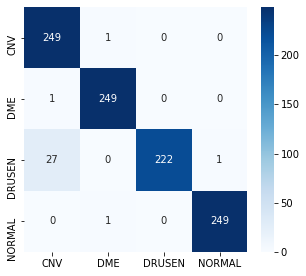

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["CNV", "DME", "DRUSEN", "NORMAL"],
                  columns = ["CNV", "DME", "DRUSEN", "NORMAL"])
plt.figure(figsize = (5,4.5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
import lime
from lime import lime_image
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def xAI(model,img_dir):
    image = Image.open(img_dir)
    image = image.resize((224, 224))
    img = np.asarray(image)
    img = img/255
    img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
    img2[:,:,0] = img # same value in each channel
    img2[:,:,1] = img
    img2[:,:,2] = img
    print(img2.shape)
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(img2, model.predict, labels=['CNV','DME','DRUSEN','NORMAL'],top_labels=4, hide_color=0,num_samples=1000)
    #plt.imshow(img)
    image, mask = explanation.get_image_and_mask(
             model.predict(img2.reshape((1,224,224,3))).argmax(axis=1)[0],
        
             positive_only=False,
        #num_features=10,
             hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

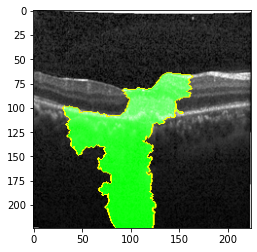

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/CNV/CNV-14999-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

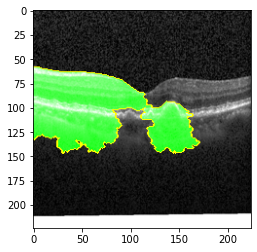

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-9943495-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

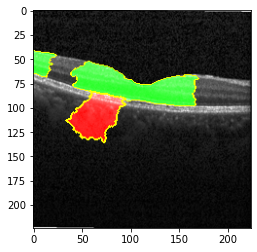

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/NORMAL/NORMAL-2647147-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

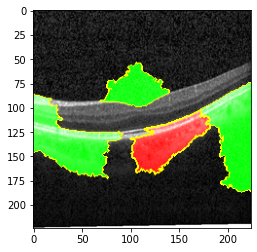

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/NORMAL/NORMAL-7084900-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

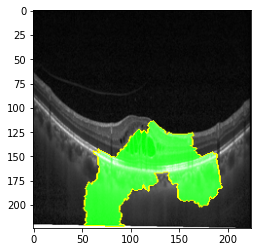

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DME/DME-6973079-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

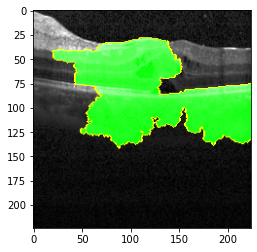

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DME/DME-6202565-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

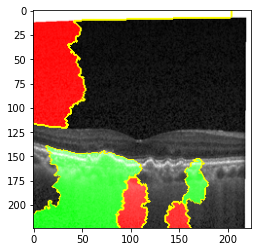

In [ ]:
#Wrong label
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-11129-2.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

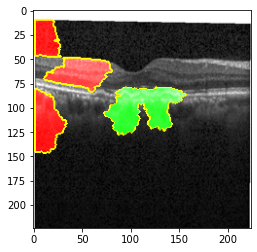

In [ ]:
#Wrong label
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-11129-5.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

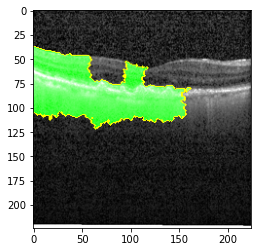

In [ ]:
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-6462845-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

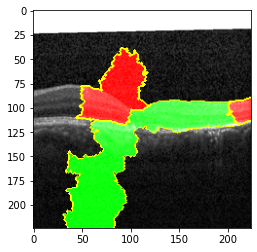

In [ ]:
#wrong label
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-449425-1.jpeg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

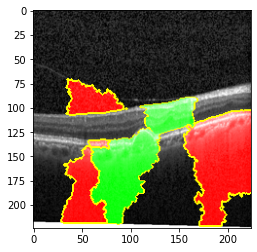

In [ ]:
#wrong label
xAI(new_model1, "D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-1763093-1.jpeg")

In [ ]:
from PIL import Image
# Open the image form working directory
image = Image.open('D:/OCT data/CellData/OCT/finaltest/DRUSEN/DRUSEN-1763093-1.jpeg')
image = image.resize((224, 224))
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

data = np.asarray(image)

data = data/255

data2 = np.zeros( ( np.array(data).shape[0], np.array(data).shape[1], 3 ) )
data2[:,:,0] = data # same value in each channel
data2[:,:,1] = data
data2[:,:,2] = data
print(data2.shape)
y = new_model1.predict(data2.reshape(1,224,224,3))

predicted_class_indices=np.argmax(y,axis=1)
print(predicted_class_indices)

None
(224, 224)
L
(224, 224, 3)
[0]


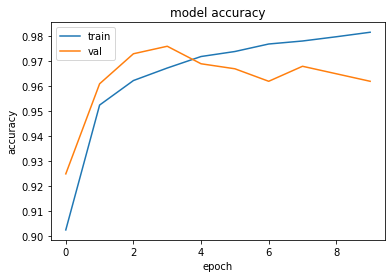

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.9026,0.9525,0.9623,0.9673,0.9719,0.9739,0.9769,0.9781,0.9798,0.9816])
plt.plot([0.9250,0.9610,0.9730,0.9760,0.9690,0.9670,0.9620,0.9680,0.9650,0.9620])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

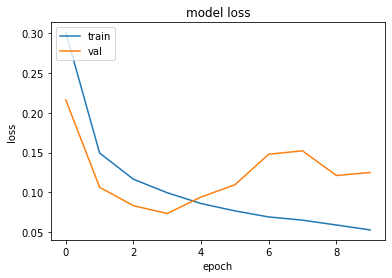

In [ ]:
plt.plot([0.3015,0.1494,0.1164,0.0994,0.0858,0.0766,0.0689,0.0649,0.0588,0.0526])
plt.plot([0.2164,0.1063,0.0831,0.0733,0.0940,0.1094,0.1479,0.1522,0.1211,0.1249])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()